### **Logistic Regression using Neural Network mindset ~ Cat vs Non-Cat image/h5 dataset**

It's time to design a simple algorithm to distinguish cat images from non-cat images.

You will build a Logistic Regression, using a Neural Network mindset. The following Figure explains why **Logistic Regression is actually a very simple Neural Network!**

<img src="images/LogReg_kiank.png" style="width:650px;height:400px;">

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage

In [5]:
path_train = '../../Data/Logistic_Regression/catvnoncat/train_catvnoncat.h5'
path_test = '../../Data/Logistic_Regression/catvnoncat/test_catvnoncat.h5'

def load_dataset():
    train_dataset = h5py.File(path_train, "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File(path_test, "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [6]:
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

In [7]:
# Example of a picture
# index =200
# plt.imshow(train_set_x_orig[index])
# print ("y = " + str(train_set_y[0, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")

In [8]:
# load dataset
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()
print(train_set_x_orig.shape, '\n')

train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

# Scaling
train_set_x = train_set_x_flatten/255.
test_set_x = test_set_x_flatten/255.

print(train_set_x.shape)
print(test_set_x.shape)

(209, 64, 64, 3) 

(12288, 209)
(12288, 50)


## General Architecture of the learning algorithm ##

**Mathematical expression of the algorithm**:

For one example $x^{(i)}$:
$$z^{(i)} = w^T x^{(i)} + b \tag{1}$$
$$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})\tag{2}$$ 
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})\tag{3}$$

The cost is then computed by summing over all training examples:
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})\tag{6}$$

**Key steps**:
In this exercise, you will carry out the following steps: 
    - Initialize the parameters of the model
    - Learn the parameters for the model by minimizing the cost  
    - Use the learned parameters to make predictions (on the test set)
    - Analyse the results and conclude

### 4.3 - Forward and Backward propagation

Now that your parameters are initialized, you can do the "forward" and "backward" propagation steps for learning the parameters.

**Exercise:** Implement a function `propagate()` that computes the cost function and its gradient.

**Hints**:

Forward Propagation:
- You get X
- You compute $A = \sigma(w^T X + b) = (a^{(1)}, a^{(2)}, ..., a^{(m-1)}, a^{(m)})$
- You calculate the cost function: $J = -\frac{1}{m}\sum_{i=1}^{m}y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)})$

Here are the two formulas you will be using: 

$$ \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T\tag{7}$$
$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})\tag{8}$$

In [5]:
def hypothesis(x, w, b):
    return np.dot(w.T, x) + b

def sigmoid(z):
    return 1/(1+np.exp(-z))

def Loss(y_hat, y):
    epsilon = 1e-8
    loss = np.mean(-(y * np.log(y_hat + epsilon) + (1 - y) * np.log(1 - y_hat + epsilon)))
    return loss

def initialize_with_zeros(dim):
    w = 0.01 * (np.random.rand(dim).reshape(-1,1) - 0.5)
    # w = np.zeros((dim,1))
    b = 0
    return w, b

In [ ]:
def propagate(w, b, X, Y):
    m = X.shape[1]
    print('X shape : ', X.shape)
    print('W shape : ', w.shape)

    y_hat = sigmoid(hypothesis(X, w, b))
    print('y_hat shape : ', y_hat.shape)

    loss = Loss(y_hat, Y)

    dw = np.dot(y_hat - Y, X.T)/m
    print('\nincorrect dw shape : ', dw.shape)

    dw = np.dot(X, (y_hat - Y).T)/m
    print('correct dw shape : ', dw.shape)

    db = np.sum(y_hat - Y)/m

    grad = {'dw': dw,
            'db': db}
    
    return grad, loss

w, b = initialize_with_zeros(train_set_x.shape[0])
grad, loss = propagate(w, b, train_set_x, train_set_y)   

In [11]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    costs = []
    
    for i in range(num_iterations): 
        grads, cost = propagate(w, b, X, Y)
        w = w - (grads['dw']*learning_rate)
        b = b - (grads['db']*learning_rate)

        if i % 10 == 0:
            costs.append(cost)

        if print_cost and i % 10 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": grads['dw'],
             "db": grads['db']}
    
    return params, grads, costs

w, b = initialize_with_zeros(train_set_x.shape[0])
params, grads, costs = optimize(w, b, train_set_x, train_set_y, num_iterations=4000, learning_rate=0.004, print_cost = True)

Cost after iteration 0: 0.702975
Cost after iteration 10: 0.634608
Cost after iteration 20: 0.607390
Cost after iteration 30: 0.587309
Cost after iteration 40: 0.571076
Cost after iteration 50: 0.557490
Cost after iteration 60: 0.545745
Cost after iteration 70: 0.535246
Cost after iteration 80: 0.525625
Cost after iteration 90: 0.516681
Cost after iteration 100: 0.508296
Cost after iteration 110: 0.500390
Cost after iteration 120: 0.492903
Cost after iteration 130: 0.485785
Cost after iteration 140: 0.478998
Cost after iteration 150: 0.472507
Cost after iteration 160: 0.466286
Cost after iteration 170: 0.460311
Cost after iteration 180: 0.454562
Cost after iteration 190: 0.449021
Cost after iteration 200: 0.443672
Cost after iteration 210: 0.438503
Cost after iteration 220: 0.433502
Cost after iteration 230: 0.428657
Cost after iteration 240: 0.423958
Cost after iteration 250: 0.419399
Cost after iteration 260: 0.414969
Cost after iteration 270: 0.410663
Cost after iteration 280: 0.406

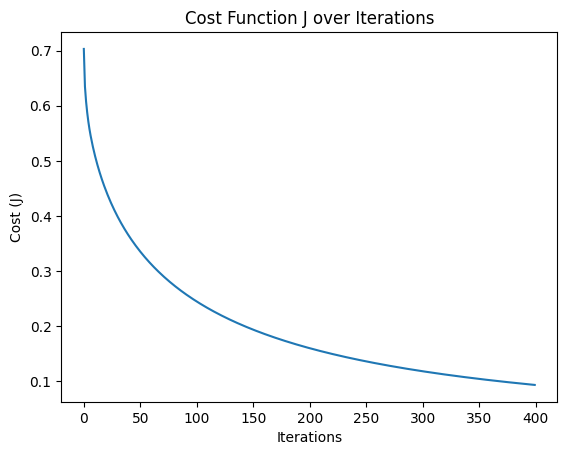

In [14]:
# learning rate : 0.005
plt.plot(costs)
plt.xlabel('Iterations')
plt.ylabel('Cost (J)')
plt.title('Cost Function J over Iterations')
plt.show()


In [15]:
def predict(w, b, X):

    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)

    y_hat = sigmoid(np.dot(w.T,X) + b)
    Y_prediction = (y_hat >= 0.5) * 1.0
    
    return Y_prediction

In [16]:
w = params["w"]
b = params["b"]

Y_prediction_test = predict(w, b, test_set_x)
Y_prediction_train = predict(w, b, train_set_x)

print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - train_set_y)) * 100))
print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - test_set_y)) * 100))

train accuracy: 99.52153110047847 %
test accuracy: 68.0 %


Cost after iteration 0: 0.6605674483725942
Cost after iteration 100: 0.5832684627501981
Cost after iteration 200: 0.4660365562908371
Cost after iteration 300: 0.3752131497395219
Cost after iteration 400: 0.3309994092225767
Cost after iteration 500: 0.3028346979411221
Cost after iteration 600: 0.27946891673551777
Cost after iteration 700: 0.2596588281084571
Cost after iteration 800: 0.2425832778314257
Cost after iteration 900: 0.22767085232447348
Cost after iteration 1000: 0.21450824374007046
Cost after iteration 1100: 0.20278716293624613
Cost after iteration 1200: 0.19227177111118016
Cost after iteration 1300: 0.18277778499681965
Cost after iteration 1400: 0.17415857419124908
Cost after iteration 1500: 0.1662956262226604
Cost after iteration 1600: 0.1590918371033927
Cost after iteration 1700: 0.1524666843530841
Cost after iteration 1800: 0.1463526860602154
Cost after iteration 1900: 0.14069275773983766
Cost after iteration 2000: 0.1354382079726206
Cost after iteration 2100: 0.130547196

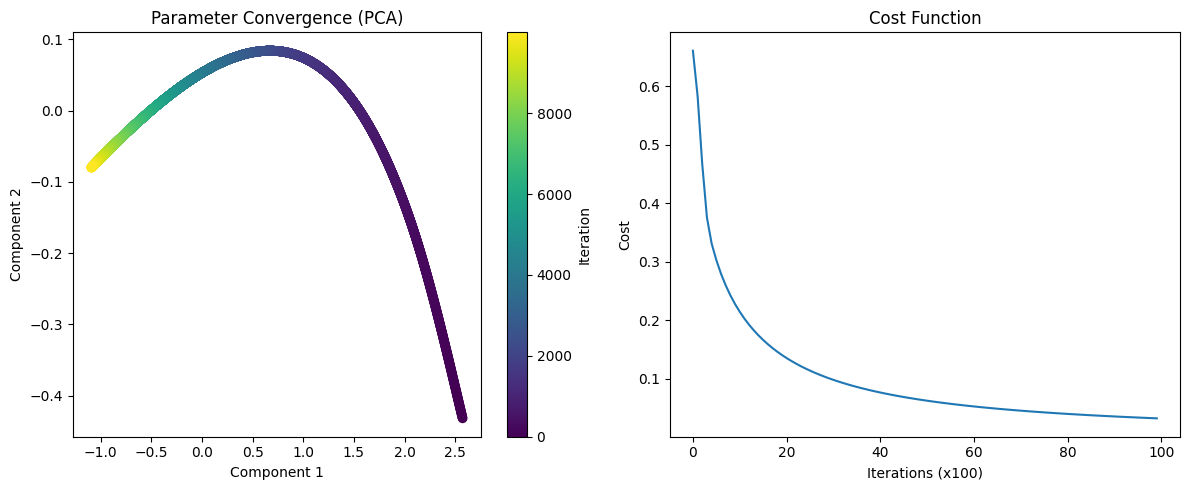

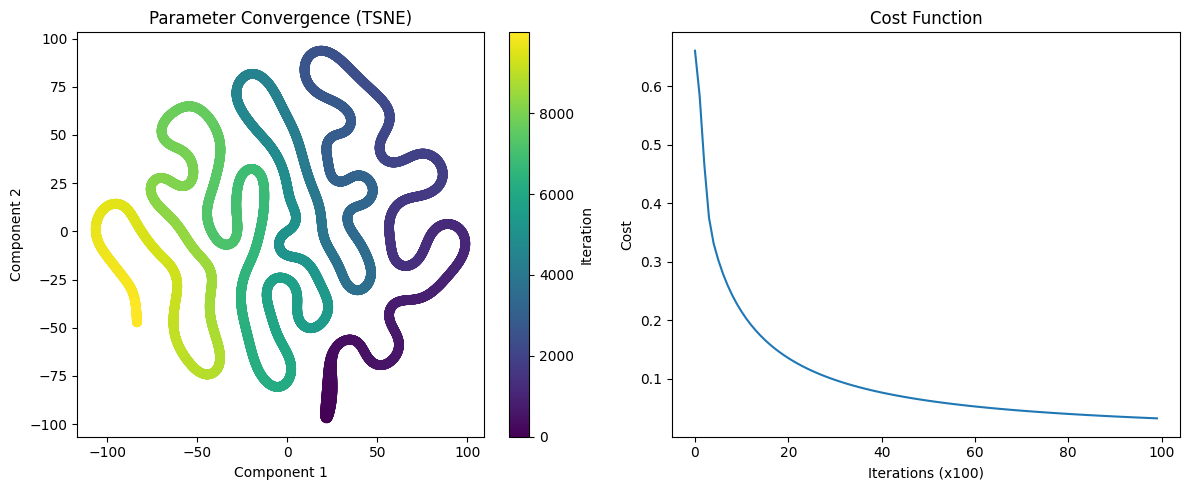

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# ... (keep your existing import statements and data loading code)

def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost=False):
    costs = []
    w_history = []
    b_history = []
    
    for i in range(num_iterations):
        grads, cost = propagate(w, b, X, Y)
        w = w - (grads['dw'] * learning_rate)
        b = b - (grads['db'] * learning_rate)
        
        # Store parameter history
        w_history.append(w.flatten())
        b_history.append(b)

        if i % 100 == 0:
            costs.append(cost)
        
        if print_cost and i % 100 == 0:
            print(f"Cost after iteration {i}: {cost}")
    
    params = {"w": w, "b": b}
    grads = {"dw": grads['dw'], "db": grads['db']}
    
    return params, grads, costs, w_history, b_history



# Continue with your prediction and accuracy calculation...

In [ ]:

def visualize_parameter_convergence(w_history, b_history, costs, method='pca'):
    # Combine w and b histories
    params_history = np.column_stack((w_history, b_history))
    
    # Apply dimensionality reduction
    if method == 'pca':
        pca = PCA(n_components=2)
        params_2d = pca.fit_transform(params_history)
    elif method == 'tsne':
        tsne = TSNE(n_components=2, random_state=42)
        params_2d = tsne.fit_transform(params_history)
    else:
        raise ValueError("Method must be 'pca' or 'tsne'")
    
    # Create the plot
    plt.figure(figsize=(12, 5))
    
    # Parameter convergence plot
    plt.subplot(121)
    scatter = plt.scatter(params_2d[:, 0], params_2d[:, 1], c=range(len(params_2d)), cmap='viridis')
    plt.colorbar(scatter, label='Iteration')
    plt.title(f'Parameter Convergence ({method.upper()})')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    
    # Cost function plot
    plt.subplot(122)
    plt.plot(costs)
    plt.title('Cost Function')
    plt.xlabel('Iterations (x100)')
    plt.ylabel('Cost')
    
    plt.tight_layout()
    plt.show()

# Main execution
w, b = initialize_with_zeros(train_set_x.shape[0])
params, grads, costs, w_history, b_history = optimize(w, b, train_set_x, train_set_y, num_iterations=10000, learning_rate=0.005, print_cost=True)

# Visualize parameter convergence using PCA
visualize_parameter_convergence(w_history, b_history, costs, method='pca')

# Visualize parameter convergence using t-SNE
visualize_parameter_convergence(w_history, b_history, costs, method='tsne')
